Prueba de jupyter notebook
Ejemplos de uso de networkx para futuras referrencias

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from random import randint


Obtenemos datos de los nodos y enlaces de los csv:

In [10]:
df_nodes = pd.read_csv(r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\algoritmo1\datos\Nodes_t1.csv', sep = ';',encoding='unicode_escape' )
df_edges = pd.read_csv(r'C:\Users\proal\Documents\UC3M\2021-2022\2\TFG\algoritmo1\datos\Edges_t1.csv', sep = ';',encoding='unicode_escape' )

Creamos Grafo direccionado con pesos múltiple:

In [ ]:
MDG = nx.MultiDiGraph()
MDG.add_nodes_from(df_nodes['Nodes'])

tuples_from_to = []
for i in range(len(df_edges)):
    tuples_from_to.append((df_edges['from'][i],df_edges['to'][i],{"weight":df_edges['weight'][i] }))

MDG.add_edges_from(tuples_from_to)

Dibujamos grafo de distintas formas

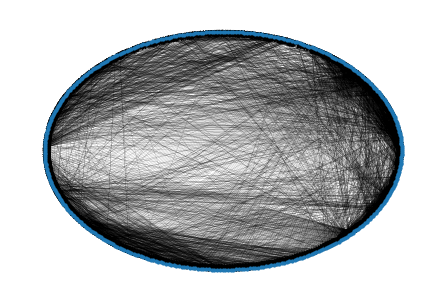

In [43]:
nx.draw_shell(MDG,node_size=10,width = 0.1)
plt.show()

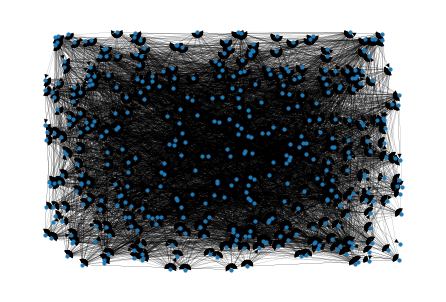

In [44]:
nx.draw_random(MDG,node_size=10,width = 0.1)
plt.show()

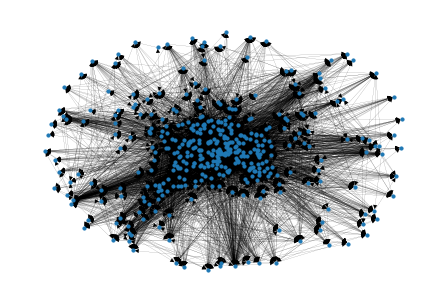

In [45]:
nx.draw_spring(MDG,node_size=10,width = 0.1)
plt.show()

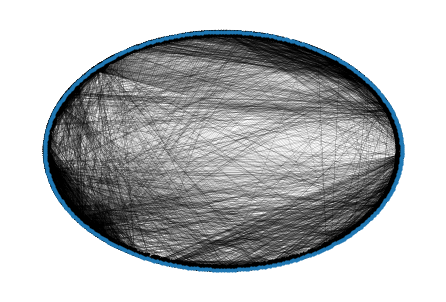

In [47]:
nx.draw_circular(MDG,node_size=10,width = 0.1)
plt.show()